In [1]:
trial_number_ml = "006"
random_state_init = 666

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model2_files = ['../../data_for_ml/ml_datasets_set2/model2_rna_bin_protein_bin/data.pkl']

# Load datasets
model2_df = load_and_concatenate_datasets(model2_files)

# Preprocess datasets
X2, y2 = preprocess_data(model2_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X2, y2)

# Output shapes
print(f"Model 2 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 2 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 17:11:12,136] A new study created in memory with name: no-name-1e4729fe-f590-4596-a80e-938aeb6c5dfb


[I 2024-05-01 17:11:45,507] Trial 3 finished with value: 0.8186221924237345 and parameters: {'n_estimators': 238, 'max_depth': 44, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 3 with value: 0.8186221924237345.


[I 2024-05-01 17:11:48,590] Trial 2 finished with value: 0.8195786222940095 and parameters: {'n_estimators': 254, 'max_depth': 70, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 2 with value: 0.8195786222940095.


[I 2024-05-01 17:11:51,945] Trial 1 finished with value: 0.8444351324170298 and parameters: {'n_estimators': 230, 'max_depth': 89, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8444351324170298.


[I 2024-05-01 17:12:16,500] Trial 4 finished with value: 0.8428412519428274 and parameters: {'n_estimators': 170, 'max_depth': 75, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8444351324170298.


[I 2024-05-01 17:12:44,052] Trial 5 finished with value: 0.828817846585195 and parameters: {'n_estimators': 336, 'max_depth': 60, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8444351324170298.


[I 2024-05-01 17:13:02,771] Trial 8 pruned. 


[I 2024-05-01 17:13:12,285] Trial 7 finished with value: 0.8667514907709343 and parameters: {'n_estimators': 288, 'max_depth': 52, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8667514907709343.


[I 2024-05-01 17:13:24,860] Trial 6 finished with value: 0.835193368482004 and parameters: {'n_estimators': 563, 'max_depth': 28, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8667514907709343.


[I 2024-05-01 17:13:29,516] Trial 9 finished with value: 0.8364682696898587 and parameters: {'n_estimators': 151, 'max_depth': 80, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8667514907709343.


[I 2024-05-01 17:13:37,967] Trial 0 finished with value: 0.8473084854579994 and parameters: {'n_estimators': 925, 'max_depth': 44, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 7 with value: 0.8667514907709343.


[I 2024-05-01 17:13:51,911] Trial 12 pruned. 


[I 2024-05-01 17:13:54,232] Trial 11 finished with value: 0.8377436788264813 and parameters: {'n_estimators': 166, 'max_depth': 93, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8667514907709343.


[I 2024-05-01 17:14:15,675] Trial 14 pruned. 


[I 2024-05-01 17:14:19,566] Trial 15 pruned. 


[I 2024-05-01 17:14:50,693] Trial 13 finished with value: 0.8460295208200002 and parameters: {'n_estimators': 433, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8667514907709343.


[I 2024-05-01 17:15:08,827] Trial 18 pruned. 


[I 2024-05-01 17:15:32,365] Trial 19 pruned. 


[I 2024-05-01 17:15:53,374] Trial 17 finished with value: 0.8536794359958959 and parameters: {'n_estimators': 432, 'max_depth': 51, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.8667514907709343.


[I 2024-05-01 17:16:11,277] Trial 10 finished with value: 0.8683468950314408 and parameters: {'n_estimators': 974, 'max_depth': 84, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 10 with value: 0.8683468950314408.


[I 2024-05-01 17:16:47,847] Trial 20 finished with value: 0.8533619805158524 and parameters: {'n_estimators': 394, 'max_depth': 38, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.8683468950314408.


[I 2024-05-01 17:16:55,523] Trial 16 finished with value: 0.8571902396407929 and parameters: {'n_estimators': 995, 'max_depth': 53, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 10 with value: 0.8683468950314408.


[I 2024-05-01 17:17:10,521] Trial 21 finished with value: 0.8520850475929255 and parameters: {'n_estimators': 463, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 10 with value: 0.8683468950314408.


[I 2024-05-01 17:18:04,239] Trial 22 finished with value: 0.8712126291408893 and parameters: {'n_estimators': 727, 'max_depth': 66, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.8712126291408893.


[I 2024-05-01 17:18:30,724] Trial 23 finished with value: 0.8699392517193388 and parameters: {'n_estimators': 717, 'max_depth': 98, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 22 with value: 0.8712126291408893.


[I 2024-05-01 17:18:32,125] Trial 24 finished with value: 0.8635667773951381 and parameters: {'n_estimators': 797, 'max_depth': 67, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8712126291408893.


[I 2024-05-01 17:18:47,822] Trial 25 finished with value: 0.8635657615376019 and parameters: {'n_estimators': 806, 'max_depth': 66, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 22 with value: 0.8712126291408893.


[I 2024-05-01 17:20:05,597] Trial 26 finished with value: 0.8753588516746411 and parameters: {'n_estimators': 766, 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:20:15,574] Trial 28 finished with value: 0.8680253761212529 and parameters: {'n_estimators': 649, 'max_depth': 100, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:20:27,146] Trial 27 finished with value: 0.8702597547719908 and parameters: {'n_estimators': 750, 'max_depth': 100, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:20:30,388] Trial 29 finished with value: 0.8584646329198794 and parameters: {'n_estimators': 684, 'max_depth': 99, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:22:22,403] Trial 30 finished with value: 0.8619688334907913 and parameters: {'n_estimators': 703, 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:22:39,180] Trial 33 finished with value: 0.8610124036205162 and parameters: {'n_estimators': 597, 'max_depth': 89, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:22:49,960] Trial 31 finished with value: 0.8616508700819796 and parameters: {'n_estimators': 755, 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:23:08,437] Trial 32 finished with value: 0.8606944402117047 and parameters: {'n_estimators': 748, 'max_depth': 89, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:24:51,290] Trial 34 finished with value: 0.8667514907709343 and parameters: {'n_estimators': 593, 'max_depth': 90, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:25:15,151] Trial 37 pruned. 


[I 2024-05-01 17:25:36,778] Trial 35 finished with value: 0.8626047603084143 and parameters: {'n_estimators': 736, 'max_depth': 93, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:26:12,084] Trial 40 pruned. 


[I 2024-05-01 17:26:19,479] Trial 36 finished with value: 0.8629242475035301 and parameters: {'n_estimators': 887, 'max_depth': 92, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:28:12,565] Trial 38 finished with value: 0.8680248681924848 and parameters: {'n_estimators': 915, 'max_depth': 83, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:28:23,492] Trial 39 finished with value: 0.8696212883105273 and parameters: {'n_estimators': 864, 'max_depth': 74, 'min_samples_split': 18, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:28:28,721] Trial 41 finished with value: 0.8683423236725281 and parameters: {'n_estimators': 617, 'max_depth': 84, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:28:35,625] Trial 42 finished with value: 0.8708936498745417 and parameters: {'n_estimators': 621, 'max_depth': 83, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:30:47,496] Trial 43 finished with value: 0.8708936498745417 and parameters: {'n_estimators': 629, 'max_depth': 71, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:30:56,045] Trial 46 finished with value: 0.8696182407379188 and parameters: {'n_estimators': 561, 'max_depth': 96, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:30:58,059] Trial 44 finished with value: 0.8715305925497008 and parameters: {'n_estimators': 623, 'max_depth': 72, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:31:23,062] Trial 48 pruned. 


[I 2024-05-01 17:31:30,335] Trial 45 finished with value: 0.8673899572323978 and parameters: {'n_estimators': 775, 'max_depth': 75, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:32:04,175] Trial 47 finished with value: 0.8638796615162689 and parameters: {'n_estimators': 558, 'max_depth': 71, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


[I 2024-05-01 17:32:08,384] Trial 49 finished with value: 0.8638796615162689 and parameters: {'n_estimators': 637, 'max_depth': 71, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8753588516746411.


Best trial for RandomForestClassifier:
  Value: 0.8753588516746411
  Params: 
    n_estimators: 766
    max_depth: 100
    min_samples_split: 4
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 766, 'max_depth': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 17:32:24,857] A new study created in memory with name: no-name-ca9c64f3-87c7-4ada-a5f4-4c3b2cbb92c5


RandomForestClassifier accuracy: 0.8650



[I 2024-05-01 17:32:37,381] Trial 3 finished with value: 0.8418888855026971 and parameters: {'n_estimators': 206, 'max_depth': 4, 'learning_rate': 0.03497930399857818, 'min_child_weight': 10, 'subsample': 0.9668993069314253, 'colsample_bytree': 0.8217603387693118, 'gamma': 4.415454846500859, 'reg_lambda': 0.3853384907626952, 'reg_alpha': 0.0594250591528837}. Best is trial 3 with value: 0.8418888855026971.


[I 2024-05-01 17:32:38,155] Trial 2 finished with value: 0.8578261664584159 and parameters: {'n_estimators': 248, 'max_depth': 7, 'learning_rate': 0.1252031745592075, 'min_child_weight': 4, 'subsample': 0.9326992534587555, 'colsample_bytree': 0.6427170622950624, 'gamma': 3.1851715400183647, 'reg_lambda': 0.07894494800927444, 'reg_alpha': 1.2753233130346262}. Best is trial 2 with value: 0.8578261664584159.


[I 2024-05-01 17:32:44,976] Trial 1 finished with value: 0.868982821849064 and parameters: {'n_estimators': 372, 'max_depth': 7, 'learning_rate': 0.14206437772136757, 'min_child_weight': 2, 'subsample': 0.8299472081351149, 'colsample_bytree': 0.6048433714118046, 'gamma': 1.2526475724393165, 'reg_lambda': 4.1244766393342225, 'reg_alpha': 0.38213113968340195}. Best is trial 1 with value: 0.868982821849064.


[I 2024-05-01 17:32:45,914] Trial 5 finished with value: 0.8552778878290109 and parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.25973997332781423, 'min_child_weight': 7, 'subsample': 0.9377120230362379, 'colsample_bytree': 0.7963515120834661, 'gamma': 3.2892478951878212, 'reg_lambda': 2.159822802895731, 'reg_alpha': 0.0728304092163382}. Best is trial 1 with value: 0.868982821849064.


[I 2024-05-01 17:32:52,166] Trial 7 finished with value: 0.8348748971444244 and parameters: {'n_estimators': 132, 'max_depth': 7, 'learning_rate': 0.2845796277767588, 'min_child_weight': 6, 'subsample': 0.9637622109818463, 'colsample_bytree': 0.6336853447961032, 'gamma': 2.504500389997604, 'reg_lambda': 0.01039890066913452, 'reg_alpha': 6.543177527557694}. Best is trial 1 with value: 0.868982821849064.


[I 2024-05-01 17:32:53,752] Trial 6 pruned. 


[I 2024-05-01 17:32:55,220] Trial 0 finished with value: 0.8536819756397362 and parameters: {'n_estimators': 842, 'max_depth': 4, 'learning_rate': 0.14022179418298156, 'min_child_weight': 4, 'subsample': 0.8466940591900782, 'colsample_bytree': 0.7603847342259353, 'gamma': 2.6990957602858185, 'reg_lambda': 6.159446529089954, 'reg_alpha': 0.24075693172993431}. Best is trial 1 with value: 0.868982821849064.


[I 2024-05-01 17:32:55,529] Trial 9 pruned. 


[I 2024-05-01 17:33:04,737] Trial 8 finished with value: 0.8613323987444002 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.052287653832344544, 'min_child_weight': 6, 'subsample': 0.6663356749658098, 'colsample_bytree': 0.9560066419195865, 'gamma': 2.4723474724578844, 'reg_lambda': 0.026743532835419817, 'reg_alpha': 0.02320362488355984}. Best is trial 1 with value: 0.868982821849064.


[I 2024-05-01 17:33:11,417] Trial 4 finished with value: 0.8657925212568189 and parameters: {'n_estimators': 963, 'max_depth': 6, 'learning_rate': 0.20234319188658376, 'min_child_weight': 6, 'subsample': 0.944696849459501, 'colsample_bytree': 0.5160474989566883, 'gamma': 1.644878359804121, 'reg_lambda': 1.8799607698421914, 'reg_alpha': 0.41786435169327546}. Best is trial 1 with value: 0.868982821849064.


[I 2024-05-01 17:33:18,458] Trial 11 finished with value: 0.8590990359511983 and parameters: {'n_estimators': 389, 'max_depth': 3, 'learning_rate': 0.2552628902922831, 'min_child_weight': 6, 'subsample': 0.6644974440967706, 'colsample_bytree': 0.6592513959578044, 'gamma': 1.1653542091370361, 'reg_lambda': 2.752101760895351, 'reg_alpha': 0.05887637342236743}. Best is trial 1 with value: 0.868982821849064.


[I 2024-05-01 17:33:27,676] Trial 10 finished with value: 0.8546353579374028 and parameters: {'n_estimators': 932, 'max_depth': 5, 'learning_rate': 0.14057807320363516, 'min_child_weight': 4, 'subsample': 0.9291110497415216, 'colsample_bytree': 0.8854128734676078, 'gamma': 2.7974356363105386, 'reg_lambda': 0.12536414830364703, 'reg_alpha': 2.6493624202656516}. Best is trial 1 with value: 0.868982821849064.


[I 2024-05-01 17:33:50,929] Trial 12 finished with value: 0.8731259968102073 and parameters: {'n_estimators': 565, 'max_depth': 10, 'learning_rate': 0.07433700778803838, 'min_child_weight': 5, 'subsample': 0.8204367765124481, 'colsample_bytree': 0.8462412256275469, 'gamma': 0.3376123455232277, 'reg_lambda': 0.08135578548754217, 'reg_alpha': 1.1878792102140745}. Best is trial 12 with value: 0.8731259968102073.


[I 2024-05-01 17:33:55,197] Trial 13 finished with value: 0.8753618992472496 and parameters: {'n_estimators': 479, 'max_depth': 10, 'learning_rate': 0.19131089487102632, 'min_child_weight': 1, 'subsample': 0.5324387157630015, 'colsample_bytree': 0.5028673478538315, 'gamma': 0.03613363005494752, 'reg_lambda': 8.152373213981503, 'reg_alpha': 0.6160223239502524}. Best is trial 13 with value: 0.8753618992472496.


[I 2024-05-01 17:33:57,425] Trial 14 finished with value: 0.871852111459889 and parameters: {'n_estimators': 989, 'max_depth': 9, 'learning_rate': 0.2025031179843305, 'min_child_weight': 1, 'subsample': 0.8003740336983244, 'colsample_bytree': 0.5001868363307318, 'gamma': 0.7170922467791803, 'reg_lambda': 0.839376389904564, 'reg_alpha': 0.7004553740943135}. Best is trial 13 with value: 0.8753618992472496.


[I 2024-05-01 17:34:00,245] Trial 15 finished with value: 0.871853127317425 and parameters: {'n_estimators': 559, 'max_depth': 9, 'learning_rate': 0.20083006505224477, 'min_child_weight': 2, 'subsample': 0.7841669074120999, 'colsample_bytree': 0.5172112627620139, 'gamma': 0.7246284372496614, 'reg_lambda': 0.7692931012449998, 'reg_alpha': 0.6843369817892114}. Best is trial 13 with value: 0.8753618992472496.


[I 2024-05-01 17:34:05,966] Trial 18 pruned. 


[I 2024-05-01 17:34:09,589] Trial 19 pruned. 


[I 2024-05-01 17:34:14,533] Trial 20 pruned. 


[I 2024-05-01 17:34:19,573] Trial 22 pruned. 


[I 2024-05-01 17:34:32,667] Trial 21 finished with value: 0.8743973425166855 and parameters: {'n_estimators': 468, 'max_depth': 8, 'learning_rate': 0.07663542936256708, 'min_child_weight': 3, 'subsample': 0.7221368291185375, 'colsample_bytree': 0.9061630431573224, 'gamma': 1.911614217388391, 'reg_lambda': 0.44350115302983356, 'reg_alpha': 0.010603925930371225}. Best is trial 13 with value: 0.8753618992472496.


[I 2024-05-01 17:34:32,836] Trial 16 finished with value: 0.8858760247462897 and parameters: {'n_estimators': 498, 'max_depth': 10, 'learning_rate': 0.09148863685315084, 'min_child_weight': 1, 'subsample': 0.7784723116264801, 'colsample_bytree': 0.506173261536256, 'gamma': 0.04719862319386342, 'reg_lambda': 0.5322606317045047, 'reg_alpha': 0.834348288697579}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:34:50,346] Trial 17 finished with value: 0.8712192322148742 and parameters: {'n_estimators': 564, 'max_depth': 10, 'learning_rate': 0.19867198272456138, 'min_child_weight': 1, 'subsample': 0.507211221720429, 'colsample_bytree': 0.5262083231438958, 'gamma': 0.006386156414139761, 'reg_lambda': 0.6471108428931186, 'reg_alpha': 1.1106853142617312}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:35:14,366] Trial 25 finished with value: 0.8708966974471499 and parameters: {'n_estimators': 712, 'max_depth': 8, 'learning_rate': 0.11040026509600484, 'min_child_weight': 1, 'subsample': 0.5693911469122438, 'colsample_bytree': 0.573663695954414, 'gamma': 0.58348415669419, 'reg_lambda': 0.2776783834742676, 'reg_alpha': 0.03493050467446088}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:35:15,583] Trial 24 finished with value: 0.8782215382114812 and parameters: {'n_estimators': 728, 'max_depth': 8, 'learning_rate': 0.06840541359471211, 'min_child_weight': 1, 'subsample': 0.7336487601128507, 'colsample_bytree': 0.9363850780119807, 'gamma': 0.47751873231255426, 'reg_lambda': 0.3367403526685284, 'reg_alpha': 0.010955555645468837}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:35:21,221] Trial 27 pruned. 


[I 2024-05-01 17:35:34,358] Trial 23 finished with value: 0.8734434522902508 and parameters: {'n_estimators': 714, 'max_depth': 8, 'learning_rate': 0.015257466377677553, 'min_child_weight': 1, 'subsample': 0.6001159243768259, 'colsample_bytree': 0.7139477680000107, 'gamma': 0.6048668059988321, 'reg_lambda': 0.21947659625743993, 'reg_alpha': 2.3012680883968417}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:35:46,653] Trial 28 finished with value: 0.8705756864657301 and parameters: {'n_estimators': 694, 'max_depth': 9, 'learning_rate': 0.17569393102401742, 'min_child_weight': 1, 'subsample': 0.6077996061489213, 'colsample_bytree': 0.7082831744233449, 'gamma': 1.101756049625647, 'reg_lambda': 0.21168629454828322, 'reg_alpha': 0.23653402920829236}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:35:49,147] Trial 26 finished with value: 0.8756737675108444 and parameters: {'n_estimators': 710, 'max_depth': 8, 'learning_rate': 0.012034352794327352, 'min_child_weight': 1, 'subsample': 0.5988254737022307, 'colsample_bytree': 0.5544295069804724, 'gamma': 0.5969489021972385, 'reg_lambda': 0.2907307265074197, 'reg_alpha': 0.010594052634027932}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:35:51,610] Trial 30 finished with value: 0.87631426568738 and parameters: {'n_estimators': 332, 'max_depth': 9, 'learning_rate': 0.16712122861126968, 'min_child_weight': 2, 'subsample': 0.8833483450257362, 'colsample_bytree': 0.5512639393818748, 'gamma': 1.0026262483390245, 'reg_lambda': 1.307915749633061, 'reg_alpha': 0.5423112438846849}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:35:53,894] Trial 29 finished with value: 0.8747193693556415 and parameters: {'n_estimators': 712, 'max_depth': 9, 'learning_rate': 0.16273218133641057, 'min_child_weight': 1, 'subsample': 0.5903072115235946, 'colsample_bytree': 0.5554230934689168, 'gamma': 0.5597812870120134, 'reg_lambda': 1.4259387897564229, 'reg_alpha': 0.4668894050841805}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:04,543] Trial 31 finished with value: 0.8734470077916274 and parameters: {'n_estimators': 316, 'max_depth': 9, 'learning_rate': 0.23025742491740864, 'min_child_weight': 2, 'subsample': 0.7707851008440996, 'colsample_bytree': 0.5487538847774592, 'gamma': 0.45820064747857836, 'reg_lambda': 1.3990503564060428, 'reg_alpha': 0.5418015329509427}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:11,875] Trial 33 finished with value: 0.8756752912971486 and parameters: {'n_estimators': 312, 'max_depth': 9, 'learning_rate': 0.11462933450508349, 'min_child_weight': 2, 'subsample': 0.8745203305204888, 'colsample_bytree': 0.7659609244283461, 'gamma': 1.4990110907387035, 'reg_lambda': 1.3695465952600634, 'reg_alpha': 0.14918247796770545}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:18,175] Trial 34 finished with value: 0.87440140594683 and parameters: {'n_estimators': 331, 'max_depth': 9, 'learning_rate': 0.05871212410701997, 'min_child_weight': 2, 'subsample': 0.8889800867317973, 'colsample_bytree': 0.7586354082488462, 'gamma': 1.4901742993897735, 'reg_lambda': 0.5178689306186758, 'reg_alpha': 0.014847547528100438}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:29,674] Trial 32 finished with value: 0.8728095571877 and parameters: {'n_estimators': 804, 'max_depth': 6, 'learning_rate': 0.06205534089995147, 'min_child_weight': 2, 'subsample': 0.8783425951158463, 'colsample_bytree': 0.7560478035777468, 'gamma': 1.5289161445616744, 'reg_lambda': 1.3293273675878667, 'reg_alpha': 0.011346180862969098}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:29,965] Trial 36 finished with value: 0.8715300846209327 and parameters: {'n_estimators': 332, 'max_depth': 7, 'learning_rate': 0.11784591627318372, 'min_child_weight': 2, 'subsample': 0.9007788026496, 'colsample_bytree': 0.7712572486256741, 'gamma': 1.5854824793436577, 'reg_lambda': 3.9500713866457535, 'reg_alpha': 0.12421716360146295}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:32,082] Trial 37 finished with value: 0.8715336401223093 and parameters: {'n_estimators': 176, 'max_depth': 7, 'learning_rate': 0.11818886525500999, 'min_child_weight': 3, 'subsample': 0.8673266773340206, 'colsample_bytree': 0.6051528808504523, 'gamma': 0.9639991951920717, 'reg_lambda': 3.2838147456983, 'reg_alpha': 0.12820312415427887}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:32,726] Trial 38 pruned. 


[I 2024-05-01 17:36:44,434] Trial 35 finished with value: 0.8769501925050032 and parameters: {'n_estimators': 817, 'max_depth': 7, 'learning_rate': 0.11483964750355, 'min_child_weight': 2, 'subsample': 0.8837649087062845, 'colsample_bytree': 0.6068146082548785, 'gamma': 0.9188395797061377, 'reg_lambda': 0.53954041120602, 'reg_alpha': 0.011979224185830133}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:46,813] Trial 39 finished with value: 0.8721680431536282 and parameters: {'n_estimators': 168, 'max_depth': 9, 'learning_rate': 0.10608757462007021, 'min_child_weight': 3, 'subsample': 0.8373816607254331, 'colsample_bytree': 0.9361051616120877, 'gamma': 0.8367340806444686, 'reg_lambda': 4.420216385600977, 'reg_alpha': 0.31494464221551044}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:47,279] Trial 41 finished with value: 0.8651510072227471 and parameters: {'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.14880365962158976, 'min_child_weight': 3, 'subsample': 0.9973105197210155, 'colsample_bytree': 0.9460169755520126, 'gamma': 2.124412364334819, 'reg_lambda': 0.5730347979357181, 'reg_alpha': 0.36884696745979373}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:48,243] Trial 40 finished with value: 0.8728095571876999 and parameters: {'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.13279516089631724, 'min_child_weight': 4, 'subsample': 0.8375892862711086, 'colsample_bytree': 0.9239067540461746, 'gamma': 0.9036021953996718, 'reg_lambda': 5.488236762368008, 'reg_alpha': 0.3213849378802545}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:36:50,927] Trial 42 pruned. 


[I 2024-05-01 17:36:53,483] Trial 43 pruned. 


[I 2024-05-01 17:36:58,748] Trial 44 pruned. 


[I 2024-05-01 17:36:59,311] Trial 45 pruned. 


[I 2024-05-01 17:37:11,521] Trial 46 finished with value: 0.8756763071546846 and parameters: {'n_estimators': 374, 'max_depth': 8, 'learning_rate': 0.10020065205293004, 'min_child_weight': 2, 'subsample': 0.9205964010728519, 'colsample_bytree': 0.5938639509233032, 'gamma': 1.3831752977269687, 'reg_lambda': 2.051289520082241, 'reg_alpha': 0.03143633147434395}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:37:18,184] Trial 49 finished with value: 0.8734434522902508 and parameters: {'n_estimators': 437, 'max_depth': 5, 'learning_rate': 0.09904164370527346, 'min_child_weight': 2, 'subsample': 0.8068210199854357, 'colsample_bytree': 0.5887583289578002, 'gamma': 0.30255406929706263, 'reg_lambda': 1.0682886474039004, 'reg_alpha': 0.07257554626890027}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:37:18,938] Trial 47 finished with value: 0.8721705827974684 and parameters: {'n_estimators': 369, 'max_depth': 7, 'learning_rate': 0.03404977682623271, 'min_child_weight': 2, 'subsample': 0.9226418420902315, 'colsample_bytree': 0.831790392956444, 'gamma': 0.334947742058762, 'reg_lambda': 1.8476878081421402, 'reg_alpha': 1.7551137102581074}. Best is trial 16 with value: 0.8858760247462897.


[I 2024-05-01 17:37:20,105] Trial 48 finished with value: 0.8753588516746411 and parameters: {'n_estimators': 366, 'max_depth': 8, 'learning_rate': 0.03409679367138118, 'min_child_weight': 2, 'subsample': 0.6959066344884794, 'colsample_bytree': 0.8470770487909969, 'gamma': 1.3071634846455944, 'reg_lambda': 0.9435049375497464, 'reg_alpha': 0.07313683912024725}. Best is trial 16 with value: 0.8858760247462897.


Best trial for XGBClassifier:
  Value: 0.8858760247462897
  Params: 
    n_estimators: 498
    max_depth: 10
    learning_rate: 0.09148863685315084
    min_child_weight: 1
    subsample: 0.7784723116264801
    colsample_bytree: 0.506173261536256
    gamma: 0.04719862319386342
    reg_lambda: 0.5322606317045047
    reg_alpha: 0.834348288697579

Best hyperparameters for XGBClassifier: {'n_estimators': 498, 'max_depth': 10, 'learning_rate': 0.09148863685315084, 'min_child_weight': 1, 'subsample': 0.7784723116264801, 'colsample_bytree': 0.506173261536256, 'gamma': 0.04719862319386342, 'reg_lambda': 0.5322606317045047, 'reg_alpha': 0.834348288697579}


[I 2024-05-01 17:39:26,447] A new study created in memory with name: no-name-7228596f-5a5a-44fb-a693-363b8d457840


XGBClassifier accuracy: 0.8764



[I 2024-05-01 17:39:27,385] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 52, 'max_depth': 15, 'learning_rate': 0.23454614828808984, 'n_estimators': 949, 'min_child_weight': 0.07765414968192032, 'min_child_samples': 1909, 'subsample': 0.8948185606997883, 'colsample_bytree': 0.8938138450859339, 'reg_alpha': 3.4946493035970783e-09, 'reg_lambda': 0.00034889864758449893}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 17:39:27,902] Trial 4 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 32, 'max_depth': 4, 'learning_rate': 0.4463417862075469, 'n_estimators': 131, 'min_child_weight': 0.07135704740427269, 'min_child_samples': 1638, 'subsample': 0.8056741299454342, 'colsample_bytree': 0.8987072798695791, 'reg_alpha': 0.005627349025194226, 'reg_lambda': 0.0003310248711834165}. Best is trial 0 with value: 0.4995215311004785.


[I 2024-05-01 17:39:28,771] Trial 2 finished with value: 0.5575361391318482 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 11, 'learning_rate': 0.3616074665249653, 'n_estimators': 710, 'min_child_weight': 0.0013790690811381326, 'min_child_samples': 1235, 'subsample': 0.9931549829767646, 'colsample_bytree': 0.9863184901086572, 'reg_alpha': 0.31781558447332786, 'reg_lambda': 0.12044005946575992}. Best is trial 2 with value: 0.5575361391318482.


[I 2024-05-01 17:39:28,824] Trial 3 finished with value: 0.7035524538038785 and parameters: {'boosting_type': 'goss', 'num_leaves': 75, 'max_depth': 7, 'learning_rate': 0.28633278664331446, 'n_estimators': 447, 'min_child_weight': 0.0027599045043266235, 'min_child_samples': 399, 'subsample': 0.9806642520157958, 'colsample_bytree': 0.9171364093429252, 'reg_alpha': 1.5111441244354697e-07, 'reg_lambda': 0.005006717764867553}. Best is trial 3 with value: 0.7035524538038785.


[I 2024-05-01 17:39:33,851] Trial 1 finished with value: 0.749445849714036 and parameters: {'boosting_type': 'dart', 'num_leaves': 84, 'max_depth': 10, 'learning_rate': 0.028373343177354148, 'n_estimators': 351, 'min_child_weight': 0.010677349513993637, 'min_child_samples': 530, 'subsample': 0.8598350443474542, 'colsample_bytree': 0.9399822491373747, 'reg_alpha': 1.1770640464369014e-08, 'reg_lambda': 0.01949336999971347}. Best is trial 1 with value: 0.749445849714036.


[I 2024-05-01 17:39:34,080] Trial 5 finished with value: 0.7943894188279036 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 96, 'max_depth': 5, 'learning_rate': 0.22462782337634385, 'n_estimators': 796, 'min_child_weight': 0.001670799798360047, 'min_child_samples': 467, 'subsample': 0.8547650529263968, 'colsample_bytree': 0.9151267370306249, 'reg_alpha': 1.396453884423623e-06, 'reg_lambda': 0.6238499441385447}. Best is trial 5 with value: 0.7943894188279036.


[I 2024-05-01 17:39:34,220] Trial 9 pruned. 


[I 2024-05-01 17:39:41,809] Trial 6 finished with value: 0.692385639837869 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': 9, 'learning_rate': 0.3716453283547262, 'n_estimators': 568, 'min_child_weight': 0.0067827173498671185, 'min_child_samples': 971, 'subsample': 0.8806535713642194, 'colsample_bytree': 0.8082229384769117, 'reg_alpha': 0.0028362950842115756, 'reg_lambda': 1.4397028768083816e-10}. Best is trial 5 with value: 0.7943894188279036.


[I 2024-05-01 17:39:42,668] Trial 11 pruned. 


[I 2024-05-01 17:39:44,897] Trial 12 pruned. 


[I 2024-05-01 17:39:50,884] Trial 13 finished with value: 0.7456170826603278 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 100, 'max_depth': -1, 'learning_rate': 0.029589010553829426, 'n_estimators': 981, 'min_child_weight': 0.001007941247994856, 'min_child_samples': 636, 'subsample': 0.922202575660743, 'colsample_bytree': 0.9436178976408501, 'reg_alpha': 3.677171316443222e-06, 'reg_lambda': 6.781547581474296e-08}. Best is trial 5 with value: 0.7943894188279036.


[I 2024-05-01 17:39:57,639] Trial 14 finished with value: 0.7615604587612633 and parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'max_depth': 4, 'learning_rate': 0.01105823899544986, 'n_estimators': 203, 'min_child_weight': 0.005411346334113777, 'min_child_samples': 68, 'subsample': 0.858530362119127, 'colsample_bytree': 0.9418167461090895, 'reg_alpha': 9.947433289131539e-08, 'reg_lambda': 0.9638993566749765}. Best is trial 5 with value: 0.7943894188279036.


[I 2024-05-01 17:40:04,109] Trial 10 finished with value: 0.7759008116701714 and parameters: {'boosting_type': 'dart', 'num_leaves': 99, 'max_depth': 0, 'learning_rate': 0.3932139713475421, 'n_estimators': 912, 'min_child_weight': 0.005720233533823698, 'min_child_samples': 584, 'subsample': 0.9886987168630592, 'colsample_bytree': 0.8923952636073574, 'reg_alpha': 5.297487303792741e-08, 'reg_lambda': 0.00013763340304077568}. Best is trial 5 with value: 0.7943894188279036.


[I 2024-05-01 17:40:07,265] Trial 8 finished with value: 0.8578256585296478 and parameters: {'boosting_type': 'goss', 'num_leaves': 56, 'max_depth': 15, 'learning_rate': 0.01902701168254877, 'n_estimators': 547, 'min_child_weight': 0.014833680418731301, 'min_child_samples': 33, 'subsample': 0.9004983482694469, 'colsample_bytree': 0.9253715829015368, 'reg_alpha': 0.0512219292957839, 'reg_lambda': 0.0021247412995872923}. Best is trial 8 with value: 0.8578256585296478.


[I 2024-05-01 17:40:20,585] Trial 7 finished with value: 0.8788635601743211 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 14, 'learning_rate': 0.038005482794892465, 'n_estimators': 726, 'min_child_weight': 0.0019725005380851084, 'min_child_samples': 23, 'subsample': 0.9765479370335961, 'colsample_bytree': 0.8851428257462496, 'reg_alpha': 5.858647364613657e-07, 'reg_lambda': 3.3180571052860825e-10}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:40:43,031] Trial 15 finished with value: 0.8661130243094709 and parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'max_depth': 4, 'learning_rate': 0.11233355723872918, 'n_estimators': 811, 'min_child_weight': 0.0041332598408229, 'min_child_samples': 25, 'subsample': 0.8395220851761137, 'colsample_bytree': 0.9462696777634647, 'reg_alpha': 3.1254398292117855e-06, 'reg_lambda': 0.9530858817577607}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:40:48,102] Trial 19 finished with value: 0.8026813559666393 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': 2, 'learning_rate': 0.11842267575084078, 'n_estimators': 700, 'min_child_weight': 0.0028046523474470827, 'min_child_samples': 235, 'subsample': 0.9422401692813809, 'colsample_bytree': 0.8651539764608228, 'reg_alpha': 8.127130547980882e-05, 'reg_lambda': 3.562872366666398e-07}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:40:51,233] Trial 17 finished with value: 0.870260770629527 and parameters: {'boosting_type': 'goss', 'num_leaves': 36, 'max_depth': 15, 'learning_rate': 0.11964354163456198, 'n_estimators': 737, 'min_child_weight': 0.02705786073810638, 'min_child_samples': 30, 'subsample': 0.9413518595177082, 'colsample_bytree': 0.8623188107055321, 'reg_alpha': 3.736879111982972e-05, 'reg_lambda': 0.9374459107295003}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:40:52,345] Trial 21 pruned. 


[I 2024-05-01 17:40:53,113] Trial 22 pruned. 


[I 2024-05-01 17:40:54,234] Trial 23 pruned. 


[I 2024-05-01 17:40:54,993] Trial 16 finished with value: 0.8629247554322982 and parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'max_depth': -1, 'learning_rate': 0.4703335097062763, 'n_estimators': 789, 'min_child_weight': 0.0029198039509183518, 'min_child_samples': 119, 'subsample': 0.9514470619040793, 'colsample_bytree': 0.8760206310415601, 'reg_alpha': 1.4101500517582268e-05, 'reg_lambda': 1.288589980564942e-06}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:41:08,098] Trial 18 finished with value: 0.8689797742764555 and parameters: {'boosting_type': 'goss', 'num_leaves': 38, 'max_depth': 15, 'learning_rate': 0.11270019518756311, 'n_estimators': 656, 'min_child_weight': 0.02472105390599008, 'min_child_samples': 23, 'subsample': 0.9474272540153628, 'colsample_bytree': 0.8610847365711137, 'reg_alpha': 8.678240775567862e-05, 'reg_lambda': 7.981690665553522e-07}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:41:09,102] Trial 26 pruned. 


[I 2024-05-01 17:41:09,742] Trial 27 pruned. 


[I 2024-05-01 17:41:11,133] Trial 28 pruned. 


[I 2024-05-01 17:41:21,093] Trial 20 finished with value: 0.8202165808267049 and parameters: {'boosting_type': 'dart', 'num_leaves': 41, 'max_depth': 6, 'learning_rate': 0.08470388843702992, 'n_estimators': 800, 'min_child_weight': 0.002711538507158285, 'min_child_samples': 272, 'subsample': 0.9524555578820122, 'colsample_bytree': 0.9629729690077502, 'reg_alpha': 5.9108630814618e-05, 'reg_lambda': 9.280164287247021e-09}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:41:21,457] Trial 30 pruned. 


[I 2024-05-01 17:41:22,179] Trial 31 pruned. 


[I 2024-05-01 17:41:22,411] Trial 32 pruned. 


[I 2024-05-01 17:41:26,438] Trial 29 finished with value: 0.8492157579821006 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'max_depth': 11, 'learning_rate': 0.06910048882389884, 'n_estimators': 761, 'min_child_weight': 0.01985810384052542, 'min_child_samples': 164, 'subsample': 0.9999471019039035, 'colsample_bytree': 0.8507535789527094, 'reg_alpha': 0.0003471952822270897, 'reg_lambda': 1.741805634720035e-09}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:41:33,600] Trial 25 finished with value: 0.8262776948160789 and parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'max_depth': 7, 'learning_rate': 0.08556019393106704, 'n_estimators': 856, 'min_child_weight': 0.003866593995870113, 'min_child_samples': 251, 'subsample': 0.966495544671037, 'colsample_bytree': 0.8400533312267531, 'reg_alpha': 5.544008775253953e-07, 'reg_lambda': 0.07018187661795795}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:41:44,232] Trial 24 finished with value: 0.8680238523349486 and parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'max_depth': 6, 'learning_rate': 0.09593078727480066, 'n_estimators': 818, 'min_child_weight': 0.003162098132552765, 'min_child_samples': 50, 'subsample': 0.9700100209172398, 'colsample_bytree': 0.8805536883282837, 'reg_alpha': 1.6194309658146948e-06, 'reg_lambda': 0.02645605574948657}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:41:46,566] Trial 36 pruned. 


[I 2024-05-01 17:41:47,107] Trial 33 finished with value: 0.8661140401670069 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 14, 'learning_rate': 0.22861161650795547, 'n_estimators': 921, 'min_child_weight': 0.0916100227770423, 'min_child_samples': 119, 'subsample': 0.8952169985554271, 'colsample_bytree': 0.88327088077379, 'reg_alpha': 8.39304540047592e-06, 'reg_lambda': 3.8080621939776357e-06}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:41:47,769] Trial 38 pruned. 


[I 2024-05-01 17:41:53,219] Trial 37 finished with value: 0.8055470900760877 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': 14, 'learning_rate': 0.11039575302121907, 'n_estimators': 694, 'min_child_weight': 0.0697812102684202, 'min_child_samples': 391, 'subsample': 0.8860295549010698, 'colsample_bytree': 0.8877049578416978, 'reg_alpha': 4.244650275241599e-08, 'reg_lambda': 0.016529350107505645}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:41:53,448] Trial 40 pruned. 


[I 2024-05-01 17:41:54,193] Trial 41 pruned. 


[I 2024-05-01 17:41:56,023] Trial 39 pruned. 


[I 2024-05-01 17:41:56,554] Trial 42 pruned. 


[I 2024-05-01 17:42:13,783] Trial 43 finished with value: 0.8511286177226506 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 15, 'learning_rate': 0.14993733218639888, 'n_estimators': 977, 'min_child_weight': 0.0021217188290284365, 'min_child_samples': 180, 'subsample': 0.9635398841677244, 'colsample_bytree': 0.857332001033596, 'reg_alpha': 0.027236582937455237, 'reg_lambda': 8.049750159019318e-05}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:42:14,197] Trial 35 finished with value: 0.8626078078810228 and parameters: {'boosting_type': 'goss', 'num_leaves': 72, 'max_depth': 14, 'learning_rate': 0.11568392379861993, 'n_estimators': 939, 'min_child_weight': 0.0037513842766489394, 'min_child_samples': 41, 'subsample': 0.8841244701321141, 'colsample_bytree': 0.8761493141175369, 'reg_alpha': 4.679059462609468e-06, 'reg_lambda': 0.013939159491683582}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:42:17,446] Trial 44 finished with value: 0.8559127987890978 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 14, 'learning_rate': 0.24563333044769217, 'n_estimators': 942, 'min_child_weight': 0.0905569292342713, 'min_child_samples': 152, 'subsample': 0.8975970550437775, 'colsample_bytree': 0.8793743200919334, 'reg_alpha': 1.3921462052897633e-05, 'reg_lambda': 2.1914811694113792e-06}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:42:22,986] Trial 46 finished with value: 0.8179786466745904 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': 13, 'learning_rate': 0.24436501037863967, 'n_estimators': 925, 'min_child_weight': 0.09073482192888242, 'min_child_samples': 350, 'subsample': 0.8989224572517414, 'colsample_bytree': 0.9010813132721757, 'reg_alpha': 2.2181876427332956e-05, 'reg_lambda': 2.2476025010499817e-06}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:42:26,586] Trial 47 finished with value: 0.8144734302461423 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 13, 'learning_rate': 0.2046424682555954, 'n_estimators': 874, 'min_child_weight': 0.05559579108503726, 'min_child_samples': 354, 'subsample': 0.9068069277150258, 'colsample_bytree': 0.9009714518801952, 'reg_alpha': 1.513128618176822e-06, 'reg_lambda': 3.5441041892905235e-07}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:42:36,323] Trial 45 finished with value: 0.8603713975152125 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': 14, 'learning_rate': 0.23497486587412175, 'n_estimators': 917, 'min_child_weight': 0.09235870503333808, 'min_child_samples': 128, 'subsample': 0.9004862261600004, 'colsample_bytree': 0.8811375199054368, 'reg_alpha': 5.590903934600307e-06, 'reg_lambda': 2.4454605231095084e-06}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:42:41,522] Trial 34 finished with value: 0.869619256595455 and parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'max_depth': 14, 'learning_rate': 0.11784161153746256, 'n_estimators': 876, 'min_child_weight': 0.0040938324436061635, 'min_child_samples': 70, 'subsample': 0.8040977672383127, 'colsample_bytree': 0.8818057598900402, 'reg_alpha': 4.0176968989332135e-06, 'reg_lambda': 0.04867663581042882}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:42:42,832] Trial 48 finished with value: 0.8619688334907913 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 8, 'learning_rate': 0.33815232577094445, 'n_estimators': 853, 'min_child_weight': 0.051329344335315434, 'min_child_samples': 105, 'subsample': 0.9113716716037369, 'colsample_bytree': 0.9086883698816801, 'reg_alpha': 0.0016743868134771343, 'reg_lambda': 0.2333791590191288}. Best is trial 7 with value: 0.8788635601743211.


[I 2024-05-01 17:42:46,660] Trial 49 finished with value: 0.8571897317120248 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 35, 'max_depth': 10, 'learning_rate': 0.045908796577730046, 'n_estimators': 823, 'min_child_weight': 0.0346431385432005, 'min_child_samples': 114, 'subsample': 0.9230977535796564, 'colsample_bytree': 0.8690676902484022, 'reg_alpha': 0.0024011438196829644, 'reg_lambda': 1.1656430018012567e-07}. Best is trial 7 with value: 0.8788635601743211.


Best trial for LGBMClassifier:
  Value: 0.8788635601743211
  Params: 
    boosting_type: gbdt
    num_leaves: 48
    max_depth: 14
    learning_rate: 0.038005482794892465
    n_estimators: 726
    min_child_weight: 0.0019725005380851084
    min_child_samples: 23
    subsample: 0.9765479370335961
    colsample_bytree: 0.8851428257462496
    reg_alpha: 5.858647364613657e-07
    reg_lambda: 3.3180571052860825e-10

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 14, 'learning_rate': 0.038005482794892465, 'n_estimators': 726, 'min_child_weight': 0.0019725005380851084, 'min_child_samples': 23, 'subsample': 0.9765479370335961, 'colsample_bytree': 0.8851428257462496, 'reg_alpha': 5.858647364613657e-07, 'reg_lambda': 3.3180571052860825e-10}


LGBMClassifier accuracy: 0.8739
LGBMClassifier accuracy: 0.8739



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_006/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

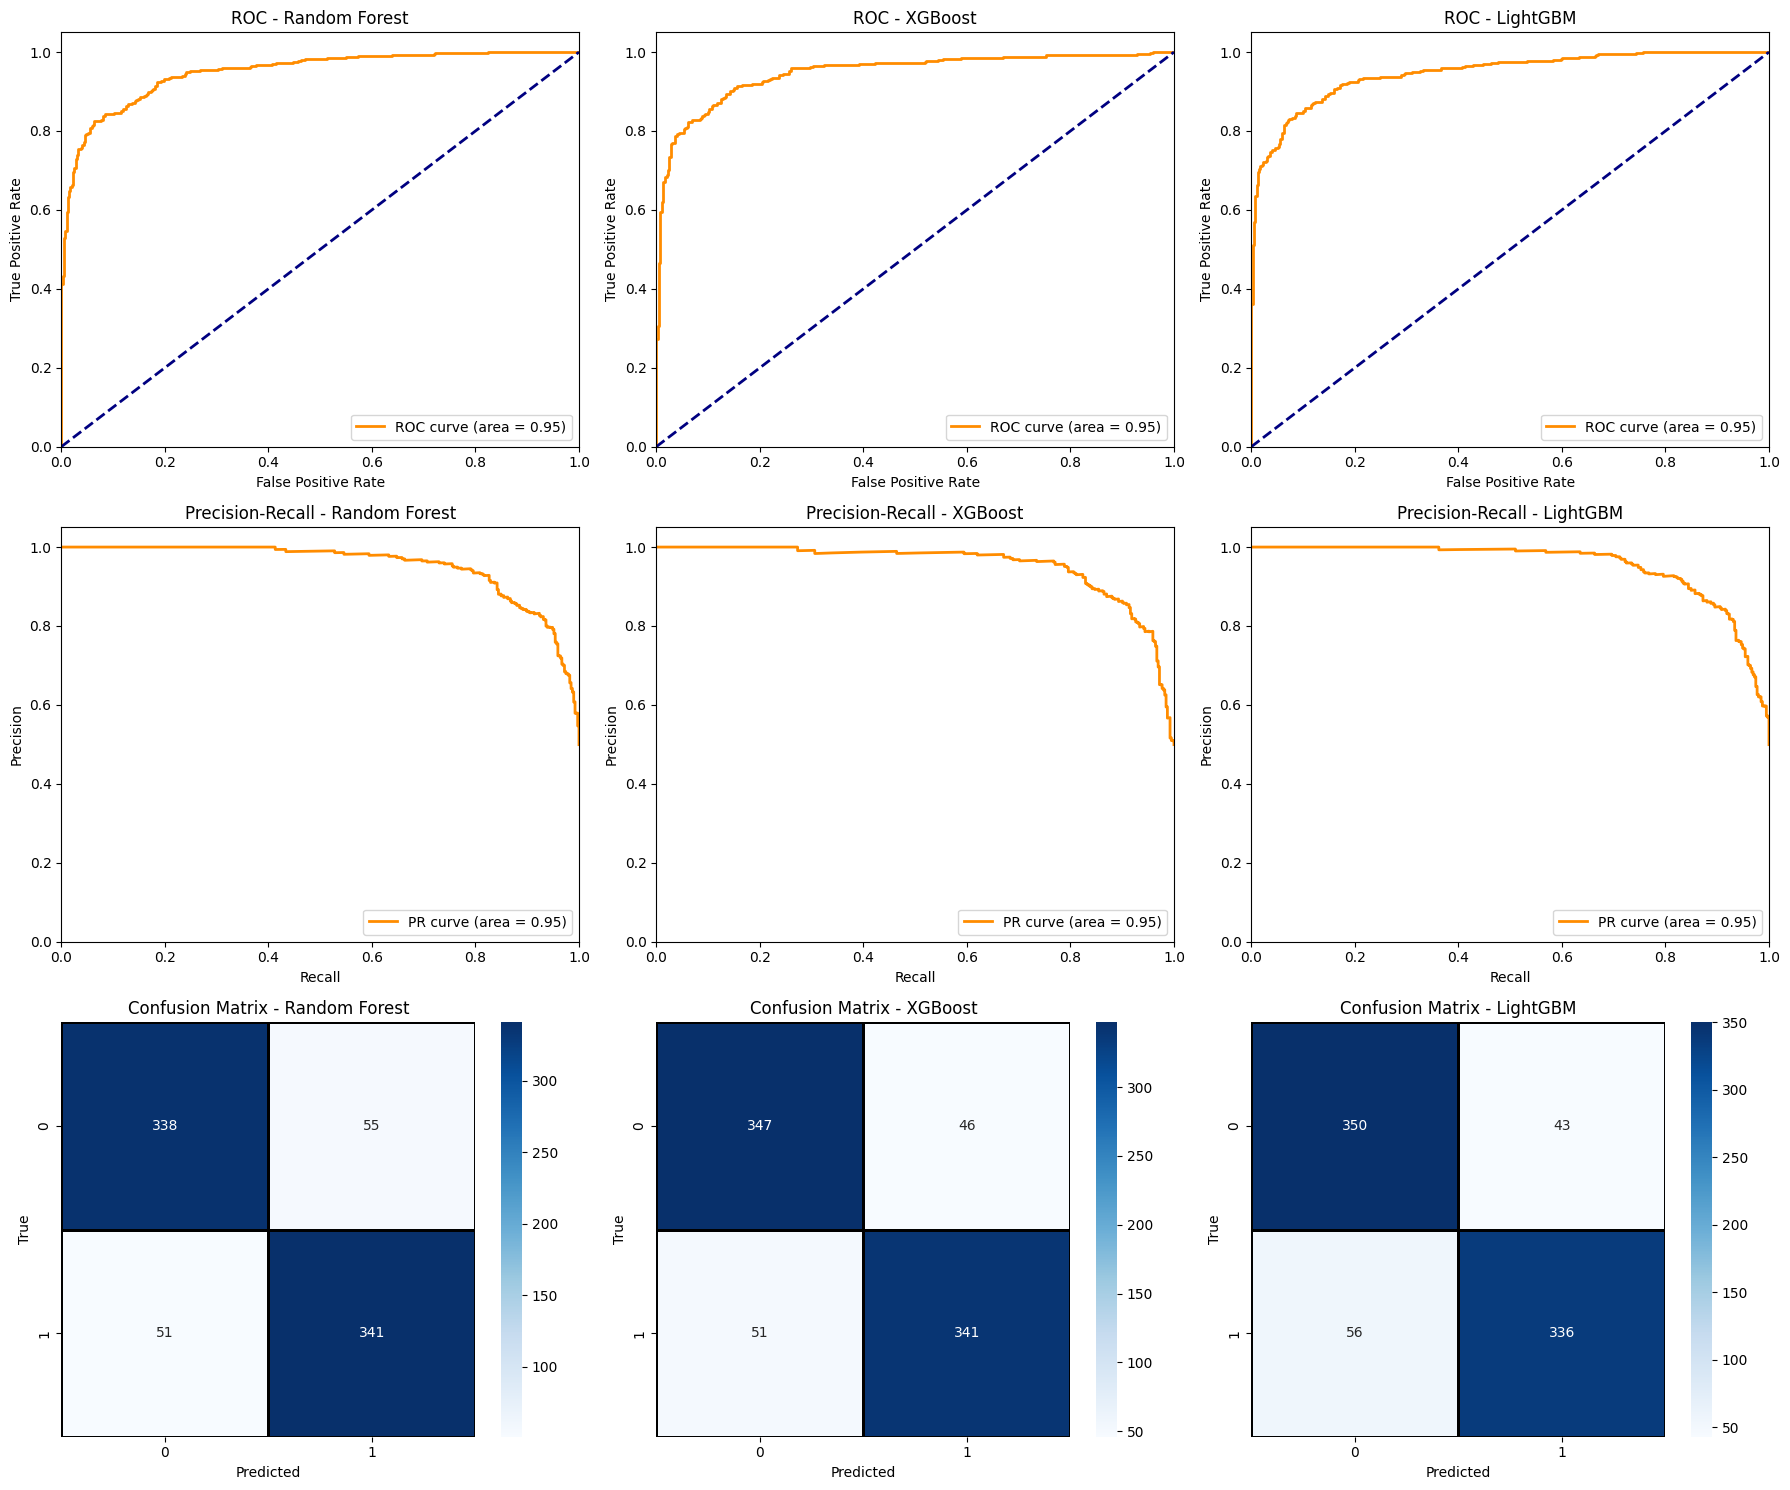

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.8649681528662421, 'Precision': 0.8611111111111112, 'Recall': 0.8698979591836735, 'F1 Score': 0.8654822335025382, 'ROC AUC': 0.9483694241055202}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.8764331210191083, 'Precision': 0.8811369509043928, 'Recall': 0.8698979591836735, 'F1 Score': 0.8754813863928114, 'ROC AUC': 0.9469803188450953}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.8738853503184714, 'Precision': 0.8865435356200527, 'Recall': 0.8571428571428571, 'F1 Score': 0.8715953307392996, 'ROC AUC': 0.9463636599678039}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.8738853503184714,
 'Precision': 0.8865435356200527,
 'Recall': 0.8571428571428571,
 'F1 Score': 0.8715953307392996,
 'ROC AUC': 0.9463636599678039}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: XGBoost with Accuracy: 0.8764


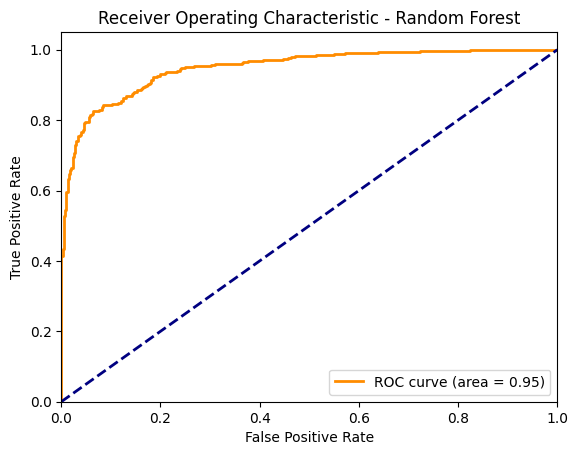

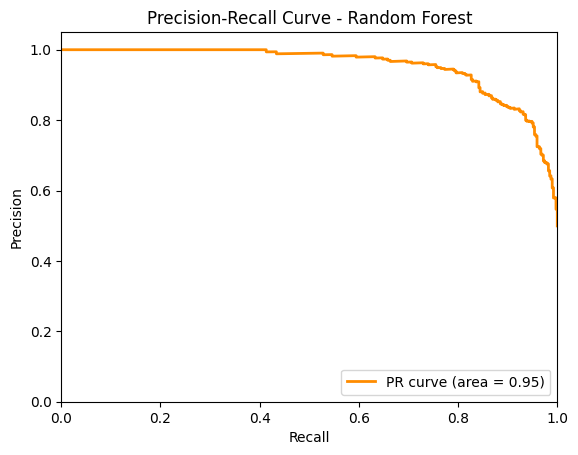

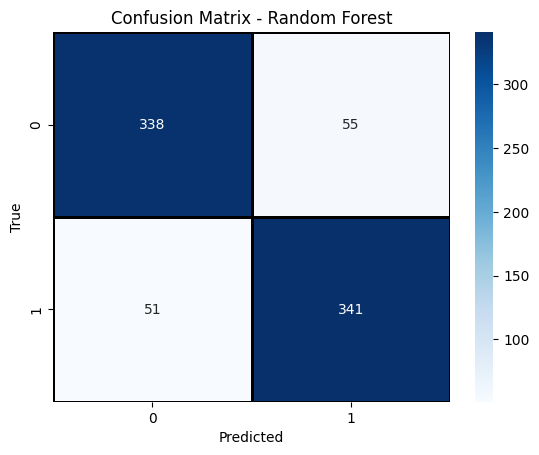

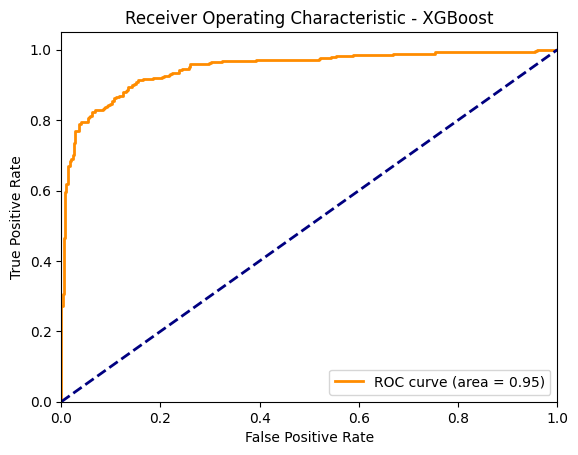

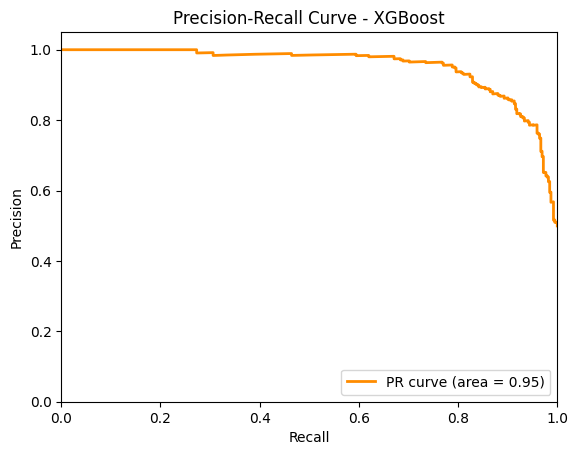

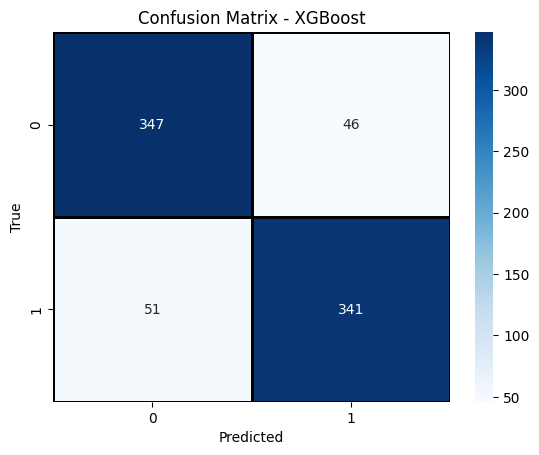

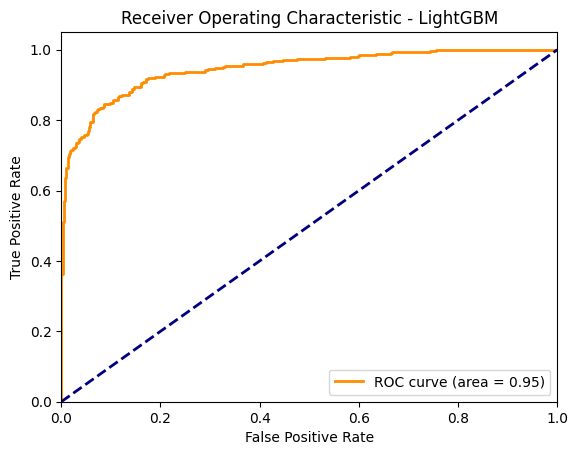

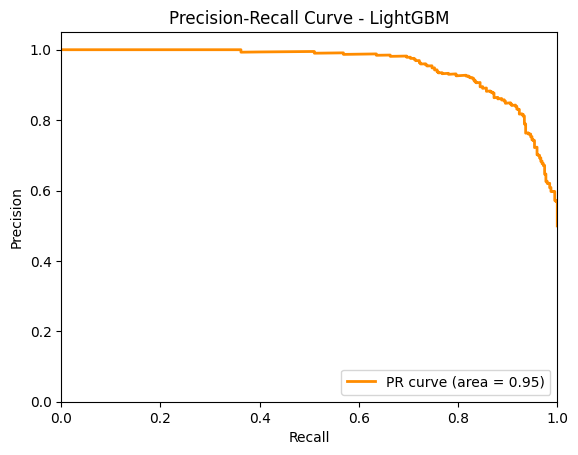

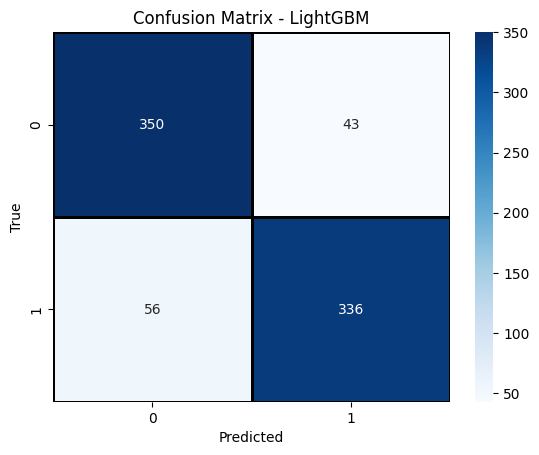

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

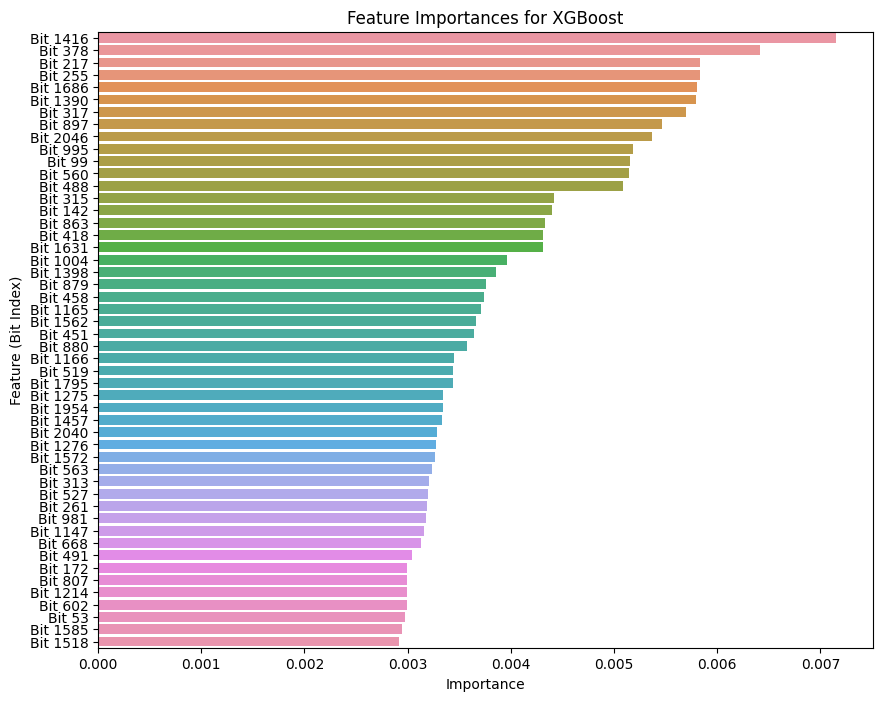

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
